In [46]:
import keras
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from keras import layers
from keras import regularizers
from keras.layers import Dropout
from keras.utils import np_utils
from sklearn import preprocessing
from keras.models import Sequential
from sklearn.utils import class_weight
from sklearn.impute import SimpleImputer
from keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import SGD, Adam
from keras.layers import Input, Dense, Activation
from sklearn.metrics import confusion_matrix as cm
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report as cr

In [47]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [48]:
df = pd.read_csv('/content/drive/MyDrive/preprocessed_file_v0_filtered', 
                 compression = "zip", header = 0, index_col = 0, sep = "\t")

In [49]:
data = df.drop("CANCER_TYPE", axis = 1)
labels = df["CANCER_TYPE"]

In [50]:
print(labels.unique(), len(labels.unique()))

['Glioma' 'Leukemia' 'Thyroid Cancer' 'Hepatobiliary Cancer'
 'Mature B-Cell Neoplasms' 'Non-Small Cell Lung Cancer'
 'Soft Tissue Sarcoma' 'Pancreatic Cancer' 'Head and Neck Cancer'
 'Esophagogastric Cancer' 'Melanoma' 'Breast Cancer' 'Endometrial Cancer'
 'Colorectal Cancer' 'Prostate Cancer' 'Renal Cell Carcinoma'
 'Bladder Cancer' 'Ovarian Cancer'] 18


In [51]:
encoder = preprocessing.LabelEncoder()
classes = encoder.fit_transform(labels)

In [52]:
x_train, x_test, y_train, y_test = train_test_split(
									data, classes, 
									test_size = 0.2, 
									random_state = 0) 

print(y_train.shape)
print(x_train.shape)
print(y_test.shape)
print(x_test.shape)

(78067,)
(78067, 1345)
(19517,)
(19517, 1345)


In [62]:
learning_rate = 0.1
opt = 'ADAM'
size_batch = 256
nb_epochs = 50

In [63]:
#7th try: Remove regularization

model = Sequential()	
	
model.add(	
	Dense(1028, input_dim = len(data.columns), activation = 'relu'))

model.add(	
	Dense(512, activation = 'relu'))

model.add(	
	Dense(128, activation = 'relu'))

model.add(	
	Dense(64, activation = 'relu'))
	
model.add(	
	Dense(len(labels.unique()), activation = 'softmax'))
	
model.compile(optimizer = opt,	
						loss = 'sparse_categorical_crossentropy',	
						metrics = ["accuracy"])	

In [64]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_25 (Dense)            (None, 1028)              1383688   
                                                                 
 dense_26 (Dense)            (None, 512)               526848    
                                                                 
 dense_27 (Dense)            (None, 128)               65664     
                                                                 
 dense_28 (Dense)            (None, 64)                8256      
                                                                 
 dense_29 (Dense)            (None, 18)                1170      
                                                                 
Total params: 1,985,626
Trainable params: 1,985,626
Non-trainable params: 0
_________________________________________________________________


In [65]:
es = EarlyStopping(
  monitor = 'val_accuracy', mode = 'max', 
	verbose = 1, patience = 10)

In [66]:
class_weights = class_weight.compute_class_weight(class_weight="balanced", classes=np.unique(y_train), y=y_train)
class_weights_d = {l:c for l,c in zip(np.unique(y_train), class_weights)}

In [67]:
print(class_weights_d)

{0: 1.6610706838588876, 1: 0.40367233391246793, 2: 0.4585594793355419, 3: 1.467204179822583, 4: 1.585760715011172, 5: 0.7312519904831488, 6: 3.0139371477106014, 7: 2.150250647275932, 8: 1.5472906013398342, 9: 2.040967320261438, 10: 1.1041383797239195, 11: 0.30139371477106014, 12: 1.1937945377251735, 13: 1.09771084676172, 14: 1.255661712668082, 15: 2.73804012345679, 16: 1.4832611339109287, 17: 3.1337106615285806}


In [68]:
history = model.fit(
	x_train, y_train, 
	validation_data = (x_test, y_test), 
	batch_size = size_batch, 
  epochs = nb_epochs, 
  class_weight = class_weights_d,
	verbose = 1, callbacks = [es])

Epoch 1/50
305/305 [==============================] - 19s 61ms/step - loss: 1.9464 - accuracy: 0.4309 - val_loss: 1.7153 - val_accuracy: 0.4900
Epoch 2/50
305/305 [==============================] - 18s 60ms/step - loss: 1.5962 - accuracy: 0.5148 - val_loss: 1.7034 - val_accuracy: 0.4877
Epoch 3/50
305/305 [==============================] - 18s 61ms/step - loss: 1.4030 - accuracy: 0.5562 - val_loss: 1.6812 - val_accuracy: 0.4943
Epoch 4/50
305/305 [==============================] - 18s 60ms/step - loss: 1.2076 - accuracy: 0.6016 - val_loss: 1.8373 - val_accuracy: 0.4816
Epoch 5/50
305/305 [==============================] - 18s 60ms/step - loss: 1.0336 - accuracy: 0.6492 - val_loss: 1.8952 - val_accuracy: 0.4893
Epoch 6/50
305/305 [==============================] - 18s 60ms/step - loss: 0.9111 - accuracy: 0.6875 - val_loss: 2.0870 - val_accuracy: 0.4889
Epoch 7/50
305/305 [==============================] - 18s 60ms/step - loss: 0.8353 - accuracy: 0.7110 - val_loss: 2.3458 - val_accuracy:

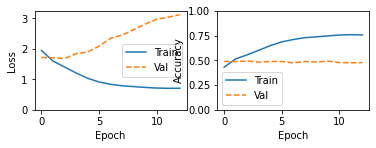

In [69]:
metrics = ['loss', 'accuracy']
for n, metric in enumerate(metrics):
  name = metric.replace("_"," ").capitalize()
  plt.subplot(2,2,n+1)
  plt.plot(history.epoch, history.history[metric],  label='Train')
  plt.plot(history.epoch, history.history['val_'+metric], linestyle="--", label='Val')
  plt.xlabel('Epoch')
  plt.ylabel(name)
  if metric == 'loss':
    plt.ylim([0, plt.ylim()[1]])
  elif metric == 'auc':
    plt.ylim([0.8,1])
  else:
    plt.ylim([0,1])

  plt.legend()

